<a href="https://colab.research.google.com/github/DtCarrot/deep-learning-flowers/blob/master/Flower_recognition_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import Counter
tf.enable_eager_execution()
tf.__version__
from tensorflow.python import keras
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, Activation
import random

In [0]:
data_root = tf.keras.utils.get_file('flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', untar=True)
# Get path of root dir
data_root = pathlib.Path(data_root)
print(data_root)

228818944/228813984 [==============================] - 1s 0us/step
/root/.keras/datasets/flower_photos


In [0]:
for flower_dir in data_root.iterdir():
  print(flower_dir)

/root/.keras/datasets/flower_photos/roses
/root/.keras/datasets/flower_photos/tulips
/root/.keras/datasets/flower_photos/daisy
/root/.keras/datasets/flower_photos/dandelion
/root/.keras/datasets/flower_photos/LICENSE.txt
/root/.keras/datasets/flower_photos/sunflowers


In [0]:
image_paths = list(data_root.glob('*/*'))
random.shuffle(image_paths)
print(image_paths[0:5])

[PosixPath('/root/.keras/datasets/flower_photos/roses/15965652160_de91389965_m.jpg'), PosixPath('/root/.keras/datasets/flower_photos/roses/22982871191_ec61e36939_n.jpg'), PosixPath('/root/.keras/datasets/flower_photos/tulips/8713397358_0505cc0176_n.jpg'), PosixPath('/root/.keras/datasets/flower_photos/tulips/7064778965_ddcc6ee9f2.jpg'), PosixPath('/root/.keras/datasets/flower_photos/daisy/7924174040_444d5bbb8a.jpg')]


In [0]:
label_names = [dir_name.name for dir_name in data_root.glob('*/') if dir_name.is_dir()]
print(label_names)

['roses', 'tulips', 'daisy', 'dandelion', 'sunflowers']


In [0]:
image_labels = [pathlib.Path(path).parent.name for path in image_paths]
print(image_labels[0:5])

['roses', 'roses', 'tulips', 'tulips', 'daisy']


In [0]:
label_encoder = LabelEncoder()
encoded_image_label = label_encoder.fit_transform(image_labels)
print(encoded_image_label[0:5])

[2 2 4 4 0]


In [0]:
def preprocess_image(image_data):
  image = cv2.resize(image_data, (150, 150))
  return image

In [0]:
def load_and_preprocess_image(path):
  return preprocess_image(cv2.imread(str(path), cv2.IMREAD_COLOR))

In [0]:
transform_images = list(map(load_and_preprocess_image, image_paths))


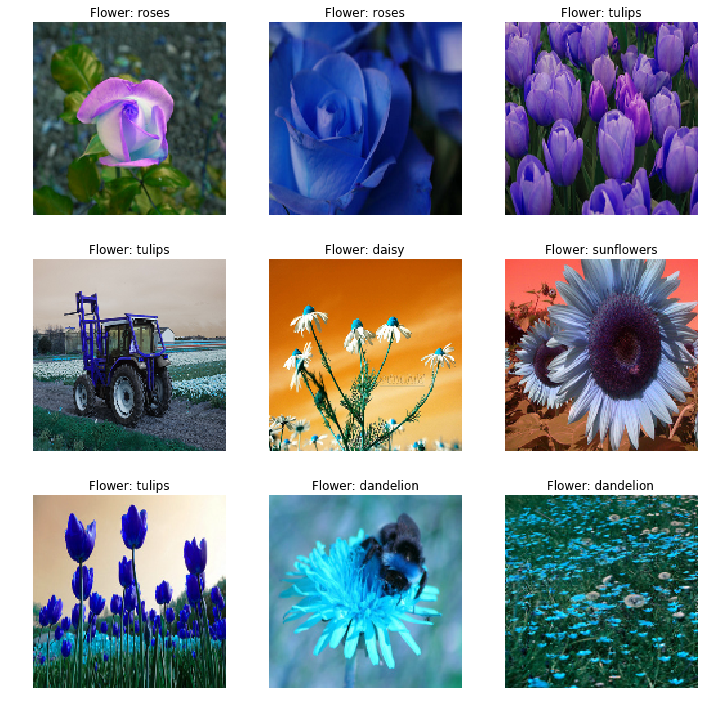

In [0]:
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(10, 10)
for x in range(3):
  for y in range(3):
    ax[x, y].set_axis_off()
    ax[x, y].imshow(transform_images[x*3 + y])
    ax[x, y].set_title('Flower: ' + image_labels[x*3 + y])
plt.tight_layout()
        

In [0]:
label_count = Counter()
for label in image_labels:
  label_count[label] += 1
label_count = dict(label_count)
print(label_count)

{'roses': 641, 'tulips': 799, 'daisy': 633, 'sunflowers': 699, 'dandelion': 898}


In [0]:
encoded_image_label = to_categorical(encoded_image_label, len(label_names))
encoded_image_label

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

<BarContainer object of 5 artists>

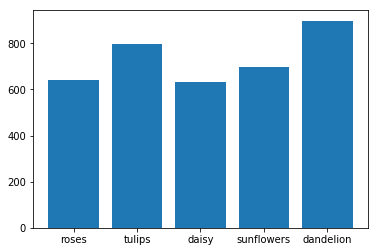

In [0]:
fig, ax = plt.subplots()
ax.bar(list(label_count.keys()), list(label_count.values()))

In [0]:
transform_images = np.array(transform_images)
transform_images = transform_images / 255
X_train, X_test, y_train, y_test = train_test_split(transform_images, encoded_image_label, test_size=0.25, random_state=42)

In [0]:
np.random.seed(42)
random.seed(42)
tf.set_random_seed(42)

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [0]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 96)        83040     
__________

In [0]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
History = model.fit_generator(datagen.flow(X_train,y_train, batch_size=32),
                              epochs = 50, validation_data = (X_test,y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0])

Epoch 1/50
Instructions for updating:
Use tf.cast instead.
86/86 [==============================] - 227s 3s/step - loss: 1.4304 - acc: 0.3452 - val_loss: 1.1961 - val_acc: 0.5098
Epoch 2/50
86/86 [==============================] - 225s 3s/step - loss: 1.1371 - acc: 0.5233 - val_loss: 1.0619 - val_acc: 0.6057
Epoch 3/50
86/86 [==============================] - 226s 3s/step - loss: 1.0527 - acc: 0.5781 - val_loss: 0.9626 - val_acc: 0.6547
Epoch 4/50
86/86 [==============================] - 225s 3s/step - loss: 0.9800 - acc: 0.6174 - val_loss: 0.8916 - val_acc: 0.6558
Epoch 5/50
86/86 [==============================] - 224s 3s/step - loss: 0.8926 - acc: 0.6621 - val_loss: 0.8090 - val_acc: 0.6993
Epoch 6/50
86/86 [==============================] - 225s 3s/step - loss: 0.8305 - acc: 0.6784 - val_loss: 0.8510 - val_acc: 0.6808
Epoch 7/50
86/86 [==============================] - 224s 3s/step - loss: 0.8054 - acc: 0.6882 - val_loss: 0.7677 - val_acc: 0.7048
Epoch 8/50
86/86 [=================

In [23]:
model.save('flower_recognition.h5')

RuntimeError: ignored

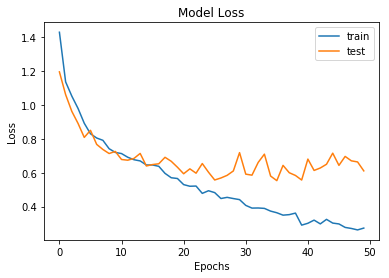

In [24]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

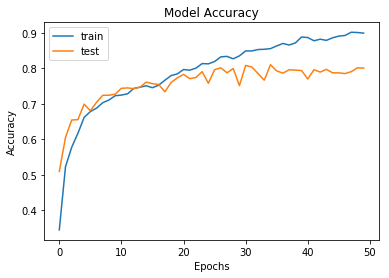

In [25]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [0]:
# getting predictions on val set.
pred=model.predict(X_test)
pred_digits=np.argmax(pred,axis=1)

In [0]:
correct_pred = []
wrong_pred = []
for i in range(len(y_test)):
  if len(correct_pred) > 6 and len(wrong_pred) > 6: break
  if np.argmax(y_test[i]) == pred_digits[i]:
    correct_pred.append(i)
  else:
    wrong_pred.append(i)

['daisy']
['tulips']
['roses']
['sunflowers']
['daisy']
['sunflowers']


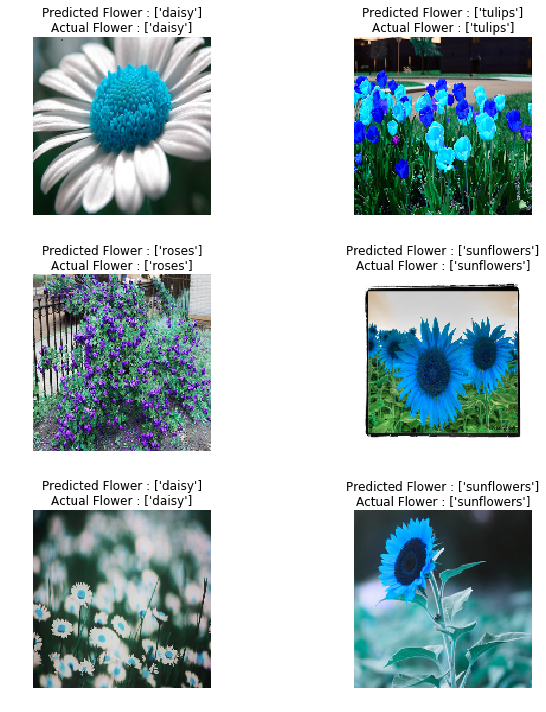

In [41]:
# Display correctly predicted images
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(10, 10)
for x in range(3):
  for y in range(2):
    ax[x, y].set_axis_off()
    ax[x, y].imshow(X_test[correct_pred[x + y*3]])
    print(label_encoder.inverse_transform([np.argmax(y_test[correct_pred[x+y*3]])]))
    ax[x, y].set_title("Predicted Flower : "+str(label_encoder.inverse_transform([pred_digits[correct_pred[x+y*3]]]))+
            "\n"+"Actual Flower : "+str(label_encoder.inverse_transform([np.argmax([y_test[correct_pred[x+y*3]]])])))
plt.tight_layout()
        